# Data Exploration and Visualization of NOM Data in NMDC (FT ICR-MS)
This notebook identifies natural organic matter (NOM) data sets in the National Microbiome Data Collaborative (NMDC), filters those datasets based on quality control metrics, and analyzes the molecular composition of the chosen datasets via heatmaps and Van Krevelen plots.

In [1]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from matplotlib.patches import Patch

Import the python script 'nmdc_api', also located in this repo folder, as a module. It contains functions that streamline API calls and help with output formatting. If loop indicates how to access script if using google colab.

In [2]:
if 'google.colab' in sys.modules:
  !wget https://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/NOM_visualizations/python/nmdc_api.py
  import nmdc_api as func
else:
  import nmdc_api as func

### Gather the IDs for processed NOM results in NMDC by filtering for data objects of type "FT ICR-MS"

Use the python requests library and the [NMDC metadata collection_name endpoint](https://api.microbiomedata.org/docs#/metadata/list_from_collection_nmdcschema__collection_name__get) to gather processed NOM results. More information regarding the API can be found [here](https://github.com/microbiomedata/NMDC_documentation/blob/main/docs/howto_guides/api_gui.md). 

The function `get_next_results` and its documentation can be found in nmdc_api.py within this folder.

Filter `data_object_set` by `data_object_type` using a keyword search of “FT ICR-MS Analysis Results”. Extract the fields `id` (necessary for traversing the NMDC schema), `url` (necessary for pulling data) and `md5_checksum` (used to check uniqueness of data set). 

In [3]:
# pull all NOM data objects
processed_nom=func.get_next_results(collection='data_object_set',\
                       filter='{"data_object_type":{"$regex": "FT ICR-MS Analysis Results"}}',\
                        max_page_size=100,fields='id,md5_checksum,url')

# clarify names
for dataobject in processed_nom:
    dataobject["processed_nom_id"] = dataobject.pop("id")
    dataobject["processed_nom_md5_checksum"] = dataobject.pop("md5_checksum")
    dataobject["processed_nom_url"] = dataobject.pop("url")

# convert to df
processed_nom_df = func.convert_df(processed_nom)
processed_nom_df

,processed_nom_id,processed_nom_md5_checksum,processed_nom_url
0,nmdc:dobj-11-003x7710,0391d9ff37a1926d5cf0eaec126ad4ff,https://nmdcdemo.emsl.pnnl.gov/nom/blanchard/r...
1,nmdc:dobj-11-00dewm52,2a532dca15798e470103ebd752a0937f,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
2,nmdc:dobj-11-00wm3313,3ce562ac512457ea54bdda05a4f01ede,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
3,nmdc:dobj-11-01kye625,38930c28eae561bc807bd01823f04167,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
4,nmdc:dobj-11-02trja88,e6bafa5fabbebfb0061aa2587e223979,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
...,...,...,...
2578,nmdc:dobj-13-zrp1qw41,98b97b78fff542b66e72f4b3f792d80f,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...
2579,nmdc:dobj-13-zsqpnm92,3e9e19910edb209d211d9f915e36b8cb,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...
2580,nmdc:dobj-13-zvnmsp76,aec0521d6a36a440e41052f8eadc0d1d,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...
2581,nmdc:dobj-13-zvzx2462,9f0d52cc46d247b8d2ba12d5842b9fb6,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...


### Continue traversing the NMDC schema by using the list of identifiers from the previous API call to query the next collection

Find the analysis records that produced these processed nom object IDs by matching object `processed_nom_id` to the `has_output` slot in the collection `workflow_execution_set`. Also extract the `has_input` slot as it will be used for the next traversal, grabbing the raw data objects that are used as input to the nom analysis records.

In [4]:
analysis_dataobj=func.get_id_results(
                                    newest_results=processed_nom,\
                                    id_field="processed_nom_id",\
                                    query_collection="workflow_execution_set",\
                                    match_id_field="has_output",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in analysis_dataobj:
    dataobject["analysis_id"] = dataobject.pop("id")
    dataobject["analysis_has_input"] = dataobject.pop("has_input")
    dataobject["analysis_has_output"] = dataobject.pop("has_output")

# convert to data frame
analysis_dataobj_df = func.convert_df(analysis_dataobj)
analysis_dataobj_df



,analysis_id,analysis_has_input,analysis_has_output
0,nmdc:wfnom-11-fwhgp651.1,[nmdc:dobj-11-hrqfj247],[nmdc:dobj-11-0dn7p856]
1,nmdc:wfnom-11-snvsmz18.1,[nmdc:dobj-11-esgqw196],[nmdc:dobj-11-0bmapy68]
2,nmdc:wfnom-11-ph9mfs20.1,[nmdc:dobj-11-sj597780],[nmdc:dobj-11-04v02904]
3,nmdc:wfnom-11-x8j6qc18.1,[nmdc:dobj-11-jjmn7962],[nmdc:dobj-11-1qhx4085]
4,nmdc:wfnom-11-479gvz55.1,[nmdc:dobj-11-rq95kp39],[nmdc:dobj-11-0cf8jk36]
...,...,...,...
2578,nmdc:wfnom-13-xn8h7a71.1,[nmdc:dobj-13-2m4tts70],[nmdc:dobj-13-x8avxs31]
2579,nmdc:wfnom-13-eb5f8063.1,[nmdc:dobj-13-b28x6912],[nmdc:dobj-13-xstcrm22]
2580,nmdc:wfnom-13-k9tdtt72.1,[nmdc:dobj-13-g1wmqa90],[nmdc:dobj-13-zkgr9031]
2581,nmdc:wfnom-13-ce2mm395.1,[nmdc:dobj-13-rwnxzx95],[nmdc:dobj-13-wm64e954]


Find the raw data objects used as input for these analysis records by matching the analysis record's `has_input` slot to the `id` slot in the collection `data_object_set`.

In [5]:
raw_dataobj=func.get_id_results(
                                    newest_results=analysis_dataobj,\
                                    id_field="analysis_has_input",\
                                    query_collection="data_object_set",\
                                    match_id_field="id",\
                                    query_fields="id,name")
# clarify names
for dataobject in raw_dataobj:
    dataobject["raw_id"] = dataobject.pop("id")
    dataobject["raw_name"] = dataobject.pop("name")

raw_df = func.convert_df(raw_dataobj)

raw_df

,raw_id,raw_name
0,nmdc:dobj-11-04embv91,Lybrand_FT_62_W_23Aug19_Alder_Infuse_p3_1_01_4...
1,nmdc:dobj-11-04ny1n21,Lybrand_FT_36_C_30Aug19_Alder_Infuse_p05_1_01_...
2,nmdc:dobj-11-09p17z03,Lybrand_Permafrost_BOG_14_CHCl3_13Dec19_Alder_...
3,nmdc:dobj-11-0cmhqk17,WHONDRS_S19S_0059_ICR_1_43_Alder_Inf_13Sept19_...
4,nmdc:dobj-11-0rgvyp97,WHONDRS_S19S_R33_14Sept2020_Alder_Infuse_p15_1...
...,...,...
2614,nmdc:dobj-13-va7e5m75,output: Brodie_150_H2O_11Mar19_R2_HESI_Neg
2615,nmdc:dobj-13-w9czqg70,output: Brodie_118_H2O_14Mar19_R3_HESI_Neg
2616,nmdc:dobj-13-wn3wd765,output: Brodie_116_H2O_12Mar19_R2_HESI_Neg
2617,nmdc:dobj-13-xrxe2y20,output: Brodie_118_MeOH_R2_21Mar19_HESI_Neg


Find the data generation records that produced these raw data objects by matching the data object's `id` slot to the `has_output` slot in the collection `data_generation_set`. Once again extract the `has_input` slot as it will be used for the next traversal, grabbing the biosample data objects that are used as input to the data generation records.

In [6]:
datageneration_dataobj=func.get_id_results(
                                    newest_results=raw_dataobj,\
                                    id_field="raw_id",\
                                    query_collection="data_generation_set",\
                                    match_id_field="has_output",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in datageneration_dataobj:
    dataobject["datageneration_id"] = dataobject.pop("id")
    dataobject["datageneration_has_output"] = dataobject.pop("has_output")
    dataobject["datageneration_has_input"] = dataobject.pop("has_input")
# convert to data frame
datageneration_dataobj_df = func.convert_df(datageneration_dataobj)
datageneration_dataobj_df


,datageneration_id,datageneration_has_output,datageneration_has_input
0,nmdc:omprc-11-adjx8k29,[nmdc:dobj-11-04embv91],[nmdc:bsm-11-ax989290]
1,nmdc:omprc-11-w1kvtj73,[nmdc:dobj-11-04ny1n21],[nmdc:bsm-11-qvtb2v69]
2,nmdc:omprc-11-rj3bqn04,[nmdc:dobj-11-09p17z03],[nmdc:bsm-11-6aqn1d84]
3,nmdc:omprc-11-a1szxs11,[nmdc:dobj-11-0cmhqk17],[nmdc:bsm-11-b7c2dc48]
4,nmdc:omprc-11-sc2gv291,[nmdc:dobj-11-0rgvyp97],[nmdc:bsm-11-m1cbn542]
...,...,...,...
2578,nmdc:omprc-11-wrvryq81,[nmdc:dobj-13-va7e5m75],[nmdc:bsm-11-qpwvgx11]
2579,nmdc:omprc-11-q55a5c26,[nmdc:dobj-13-w9czqg70],[nmdc:bsm-11-39j0y956]
2580,nmdc:omprc-11-fbpp0f91,[nmdc:dobj-13-wn3wd765],[nmdc:bsm-11-1srsh991]
2581,nmdc:omprc-11-xcg0qc34,[nmdc:dobj-13-xrxe2y20],[nmdc:bsm-11-39j0y956]


Find the biosample data objects used as input for these data generation records by matching the processing record's `has_input` slot to the `id` slot in the collection `biosample_set`. Query all fields in this API call by leaving `query_fields` as an empty list and utilize informative columns to group biosamples into a `type`. 

In [7]:
biosample_dataobj=func.get_id_results(
                                    newest_results=datageneration_dataobj,\
                                    id_field="datageneration_has_input",\
                                    query_collection="biosample_set",\
                                    match_id_field="id",\
                                    query_fields="")

# clarify names
for dataobject in biosample_dataobj:
    dataobject["biosample_id"] = dataobject.pop("id")

# convert to data frame
biosample_dataobj_df = func.convert_df(biosample_dataobj)

biosample_dataobj_df


,env_broad_scale,env_local_scale,env_medium,samp_name,emsl_biosample_identifiers,carb_nitro_ratio,collection_date,cur_vegetation,depth,ecosystem,...,insdc_biosample_identifiers,add_date,location,mod_date,experimental_factor,tot_org_carb,sample_link,community,alternative_identifiers,igsn_biosample_identifiers
0,{'has_raw_value': 'urban biome [ENVO:01000249]...,{'has_raw_value': 'woodland clearing [ENVO:000...,{'has_raw_value': 'forest soil [ENVO:00002261]...,WLUP_CoreB_TOP,[UUID:WLUP-CB-T-a07898a8-bff9-4bc2-ae4c-345682...,"{'has_raw_value': '15.699', 'type': 'nmdc:Quan...","{'has_raw_value': '2022-04-04T00:00:00', 'type...","{'has_raw_value': 'Deciduous trees, skunk cabb...","{'has_minimum_numeric_value': 0.0, 'has_maximu...",Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"{'has_raw_value': 'ENVO:00000446', 'term': {'i...","{'has_raw_value': 'ENVO:00000516', 'term': {'i...","{'has_raw_value': 'ENVO:00001998', 'term': {'i...",Lybrand_Permafrost_BOG_12_H2O,NaN,NaN,"{'has_raw_value': '2018-07-22 00:00:00', 'type...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"{'has_raw_value': 'ENVO:00000446', 'term': {'i...","{'has_raw_value': 'ENVO:01000888', 'term': {'i...","{'has_raw_value': 'ENVO:00001998', 'term': {'i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,{'has_raw_value': 'anthropogenic terrestrial b...,{'has_raw_value': 'agricultural field [ENVO:00...,{'has_raw_value': 'agricultural soil [ENVO:000...,PRS2_CoreB_TOP,[UUID:PSR2-CB-T-177b015d-e006-4aca-977d-c9c118...,"{'has_raw_value': '9.6', 'type': 'nmdc:Quantit...","{'has_raw_value': '2022-02-04', 'type': 'nmdc:...",NaN,"{'has_minimum_numeric_value': 0.0, 'has_maximu...",Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'has_raw_value': 'ENVO:00000446', 'term': {'i...","{'has_raw_value': 'ENVO:01000861', 'term': {'i...","{'has_raw_value': 'ENVO:00001998', 'term': {'i...",Lybrand_Permafrost_HE_02_CHCl3,NaN,NaN,"{'has_raw_value': '2018-07-18 00:00:00', 'type...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,"{'has_raw_value': 'ENVO:00000873', 'term': {'i...","{'has_raw_value': 'ENVO:00000022', 'term': {'i...","{'has_raw_value': 'ENVO:01000017', 'term': {'i...",GW-RW S2_00_10,[emsl:63ca47e0-6647-11eb-ae93-0242ac130002],NaN,"{'has_raw_value': '2014-04-01', 'type': 'nmdc:...",NaN,NaN,Environmental,...,NaN,NaN,"Columbia River, Washington, USA",NaN,NaN,NaN,NaN,microbial communities,NaN,NaN
2174,"{'has_raw_value': 'ENVO:01000221', 'term': {'i...","{'has_raw_value': 'ENVO:00005784', 'term': {'i...","{'has_raw_value': 'ENVO:00005774', 'term': {'i...",NaN,[emsl:2f7118c0-5dd1-11ec-bf63-0242ac130002],NaN,"{'has_raw_value': '2016-08-23 00:00:00', 'type...",NaN,"{'has_numeric_value': 0.1, 'has_raw_value': '0...",Environmental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2175,"{'has_raw_value': 'ENVO:00000873', 'term': {'i...","{'has_raw_value': 'ENVO:00000022', 'term': {'i...","{'has_raw_value': 'ENVO:01000017', 'term': {'i...",GW-RW S3_30_40,[emsl:63ca5014-6647-11eb-ae93-0242ac130002],NaN,"{'has_raw_value': '2014-04-01', 'type': 'nmdc:...",NaN,NaN,Environmental,...,NaN,NaN,"Columbia River, Washington, USA",NaN,NaN,NaN,NaN,microbial communities,NaN,NaN
2176,"{'has_raw_value': 'ENVO:00000873', 'term': {'i...","{'has_raw_value': 'ENVO:00000022', 'term': {'i...","{'has_raw_value': 'ENVO:01000017', 'term': {'i...",GW-RW S2_10_20,[emsl:63ca489e-6647-11eb-ae93-0242ac130002],NaN,"{'has_raw_value': '2014-04-01', 'type': 'nmdc:...",NaN,NaN,Environmental,...,NaN,NaN,"Columbia River, Washington, USA",NaN,NaN,NaN,NaN,microbial communities,NaN,NaN


Assign a general type for each sample by parsing their ENVO IDs. This was done manually by searching ENVO ID's on the [ontology search website](https://www.ebi.ac.uk/ols4/ontologies/envo).

In [8]:
biosample_dataobj_flat=pd.json_normalize(biosample_dataobj)
biosample_dataobj_flat_df=func.convert_df(biosample_dataobj_flat)

biosample_dataobj_flat_df['sample_type']=""

biosample_dataobj_flat_df['env_medium.term.id'].drop_duplicates()

biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.name'].str.contains('soil', na = False),'sample_type'] = 'soil'

biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002261","ENVO:00001998","ENVO:00002259",
                                                                                    "ENVO:01001616","ENVO:00005750","ENVO:00005761",
                                                                                    "ENVO:00005760","ENVO:00005773","ENVO:00005802",
                                                                                    "ENVO:00005774"]),'sample_type'] = 'soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002042"]),'sample_type'] = 'water'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002007"]),'sample_type'] = 'sediment'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:01000017"]),'sample_type'] = 'sand'

#filter to desired metadata columns
biosample_dataobj_flat_df=biosample_dataobj_flat_df[['biosample_id','geo_loc_name.has_raw_value','env_medium.term.name','env_medium.term.id','sample_type']]

biosample_dataobj_flat_df

,biosample_id,geo_loc_name.has_raw_value,env_medium.term.name,env_medium.term.id,sample_type
0,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil
1,nmdc:bsm-11-17ag3b30,"USA: Alaska, Coldfoot",soil,ENVO:00001998,soil
2,nmdc:bsm-11-26bgjj05,"USA: ND, Stutsman",NaN,ENVO:00001998,soil
3,nmdc:bsm-11-2d3eam48,"USA: Washington, Prosser Non-irrigated Bare",agricultural soil,ENVO:00002259,soil
4,nmdc:bsm-11-2n9dds87,"USA: Alaska, Healy",soil,ENVO:00001998,soil
...,...,...,...,...,...
2173,nmdc:bsm-13-rrsd4804,"USA: Columbia River, Washington",NaN,ENVO:01000017,sand
2174,nmdc:bsm-13-tk2ebg43,"USA: Minnesota, Marcel Experimental Forest, Sp...",NaN,ENVO:00005774,soil
2175,nmdc:bsm-13-tr7n0581,"USA: Columbia River, Washington",NaN,ENVO:01000017,sand
2176,nmdc:bsm-13-ty597764,"USA: Columbia River, Washington",NaN,ENVO:01000017,sand


### Create final data frame of relevant metadata and NMDC schema information for each NOM processed data object

Create merged dataframe with results from schema traversal and metadata

In [9]:
#match all processed nom objects (via processed_nom_id) to analysis objects (via analysis_has_output) and expand lists has_input and has_output
processed_obj_to_analysis_df=func.merge_df(processed_nom_df,analysis_dataobj_df,"processed_nom_id","analysis_has_output",[],["analysis_has_input","analysis_has_output"])

#match raw data objects (via raw_id) to all_analysis_df (via analysis_has_input)
processed_obj_to_raw_df=func.merge_df(raw_df,processed_obj_to_analysis_df,"raw_id","analysis_has_input",[],[])

#match processed_obj_to_raw_df (via raw_id) to data generation objects (via datageneration_has_output) and expand lists has_input and has_output
processed_obj_to_datagen_df=func.merge_df(processed_obj_to_raw_df,datageneration_dataobj_df,"raw_id","datageneration_has_output",[],["datageneration_has_input","datageneration_has_output"])

#match biosample objects (via biosample_id) to processed_obj_to_datagen_df (via datageneration_has_input)
merged_df=func.merge_df(biosample_dataobj_flat_df,processed_obj_to_datagen_df,"biosample_id","datageneration_has_input",[],[])

merged_df

,biosample_id,geo_loc_name.has_raw_value,env_medium.term.name,env_medium.term.id,sample_type,raw_id,raw_name,processed_nom_id,processed_nom_md5_checksum,processed_nom_url,analysis_id,analysis_has_input,analysis_has_output,datageneration_id,datageneration_has_output,datageneration_has_input
0,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-gdhnkg66,1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300...,nmdc:dobj-11-0dyc2f79,9ace043441672422f7991411014ab9cb,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-xnhh0t17.1,nmdc:dobj-11-gdhnkg66,nmdc:dobj-11-0dyc2f79,nmdc:omprc-11-wj8myx84,nmdc:dobj-11-gdhnkg66,nmdc:bsm-11-12esnc57
1,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-vkheqz50,1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300...,nmdc:dobj-11-07gsmc68,9363e9de79c39013257ddb4d967006b2,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-r8x4ew73.1,nmdc:dobj-11-vkheqz50,nmdc:dobj-11-07gsmc68,nmdc:omprc-11-s2590964,nmdc:dobj-11-vkheqz50,nmdc:bsm-11-12esnc57
2,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-qt6pmm77,1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300...,nmdc:dobj-11-jj2r0a49,a502ec422a6f960972b759b143d8ad9c,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-edr3rn40.1,nmdc:dobj-11-qt6pmm77,nmdc:dobj-11-jj2r0a49,nmdc:omprc-11-6mbfsz04,nmdc:dobj-11-qt6pmm77,nmdc:bsm-11-12esnc57
3,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-z002ga43,1000S_WLUP_FTMS_SPE_TOP_2_run2_Fir_22Apr22_300...,nmdc:dobj-11-mmdwds36,dff9718e9428ec3aa77fed987deb637d,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-zr24j979.1,nmdc:dobj-11-z002ga43,nmdc:dobj-11-mmdwds36,nmdc:omprc-11-6ejjgv07,nmdc:dobj-11-z002ga43,nmdc:bsm-11-12esnc57
4,nmdc:bsm-11-12esnc57,"USA: Maryland, Winters Lane Upper Soil Pit",forest soil,ENVO:00002261,soil,nmdc:dobj-11-hdd01t09,1000S_WLUP_FTMS_SPE_TOP_1_run1_Fir_22Apr22_300...,nmdc:dobj-11-s42fww29,05cf8e9c0394dbdf80c3c6b89a4f3956,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-befkpb58.1,nmdc:dobj-11-hdd01t09,nmdc:dobj-11-s42fww29,nmdc:omprc-11-mcataq54,nmdc:dobj-11-hdd01t09,nmdc:bsm-11-12esnc57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,nmdc:bsm-13-pwrd7087,"USA: Minnesota, Marcel Experimental Forest, Sp...",NaN,ENVO:00005774,soil,nmdc:dobj-13-jgx9v635,Rachael_21T_04-45_M_14Mar17_leopard_Infuse.raw,nmdc:dobj-13-wdr7zv47,9d3f15a21760ef50d957c4f1044f0d62,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-fmevq695.1,nmdc:dobj-13-jgx9v635,nmdc:dobj-13-wdr7zv47,nmdc:omprc-13-11nhsd04,nmdc:dobj-13-jgx9v635,nmdc:bsm-13-pwrd7087
9464,nmdc:bsm-11-hbdmpd66,USA: Colorado,NaN,ENVO:00005802,soil,nmdc:dobj-13-9za40068,output: Brodie_153_w_r2_29Jan19_HESI_neg,nmdc:dobj-13-qxc45786,927a408981415d70c2111b54f37299da,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-meh2bb53.1,nmdc:dobj-13-9za40068,nmdc:dobj-13-qxc45786,nmdc:omprc-11-77zzn373,nmdc:dobj-13-9za40068,nmdc:bsm-11-hbdmpd66
9465,nmdc:bsm-11-hbdmpd66,USA: Colorado,NaN,ENVO:00005802,soil,nmdc:dobj-13-qw6d7s16,output: Brodie_153_w_r3_31Jan19_HESI_neg,nmdc:dobj-13-sajy7y74,e8571cad964446d32e686e9e94cb106b,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-5csd6908.1,nmdc:dobj-13-qw6d7s16,nmdc:dobj-13-sajy7y74,nmdc:omprc-11-bgtzcs75,nmdc:dobj-13-qw6d7s16,nmdc:bsm-11-hbdmpd66
9468,nmdc:bsm-13-tk2ebg43,"USA: Minnesota, Marcel Experimental Forest, Sp...",NaN,ENVO:00005774,soil,nmdc:dobj-13-p6nbwp18,Rachael_21T_19-15_M_14Mar17_leopard_Infuse.raw,nmdc:dobj-13-n2g0fg49,8ace8bbe037be3d09031d60f12d56010,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-2w27bd07.1,nmdc:dobj-13-p6nbwp18,nmdc:dobj-13-n2g0fg49,nmdc:omprc-13-dsva8j03,nmdc:dobj-13-p6nbwp18,nmdc:bsm-13-tk2ebg43


Use the md5_checksum to check that each row/processed NOM object has an associated url that is unique

In [10]:
#are there any md5_checksum values that occur more than once (i.e. are associated with more than one processed nom id)
len(merged_df[merged_df.duplicated('processed_nom_md5_checksum')]['processed_nom_md5_checksum'].unique())==0

True

Check that all processed nom results from first query are present in merged dataframe.

In [11]:
processed_nom_df['processed_nom_id'].sort_values().tolist()==merged_df['processed_nom_id'].sort_values().tolist()

True

Clean up final dataframe, removing unneeded/intermediate identifier columns from schema traversal.

In [12]:
column_list = merged_df.columns.tolist()
columns_to_keep = ["biosample_id","processed_nom_id","sample_type","processed_nom_url"]
columns_to_remove = list(set(column_list).difference(columns_to_keep))

# Drop unnecessary columns
merged_df_cleaned = merged_df.drop(columns=columns_to_remove)

# remove duplicate rows when keeping only necessary columns (should remove none)
final_df=merged_df_cleaned.drop_duplicates(keep="first")

final_df


,biosample_id,sample_type,processed_nom_id,processed_nom_url
0,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-0dyc2f79,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
1,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-07gsmc68,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
2,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-jj2r0a49,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
3,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-mmdwds36,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
4,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-s42fww29,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
...,...,...,...,...
9460,nmdc:bsm-13-pwrd7087,soil,nmdc:dobj-13-wdr7zv47,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
9464,nmdc:bsm-11-hbdmpd66,soil,nmdc:dobj-13-qxc45786,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...
9465,nmdc:bsm-11-hbdmpd66,soil,nmdc:dobj-13-sajy7y74,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...
9468,nmdc:bsm-13-tk2ebg43,soil,nmdc:dobj-13-n2g0fg49,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...


### Calculate quality control statistics on processed nom results (this takes a while to run)

Explore what the files associated with these NOM data objects look like. 

In [13]:
#example file
url=final_df.iloc[0]["processed_nom_url"]

#pull data as csv using url
response = requests.get(url)
csv_data = StringIO(response.text)
csv_df = pd.read_csv(csv_data)
csv_data.close()
csv_df

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),...,Mono Isotopic Index,Molecular Formula,C,H,O,N,S,13C,18O,34S
0,10,121.029630,121.029532,121.029503,2.053749e+07,1733.686860,1.862520e+06,94.864999,-1,0.236952,...,NaN,C7 H6 O2,7.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN
1,14,125.024551,125.024447,125.024418,6.872170e+06,460.820768,1.803007e+06,31.743342,-1,0.235671,...,NaN,C6 H6 O3,6.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN
2,19,127.040191,127.040084,127.040068,6.932442e+06,558.934590,1.774400e+06,32.021746,-1,0.125863,...,NaN,C6 H8 O3,6.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN
3,21,127.076580,127.076473,127.076453,7.184993e+06,547.351481,1.774748e+06,33.188306,-1,0.157776,...,NaN,C7 H12 O2,7.0,12.0,2.0,NaN,NaN,NaN,NaN,NaN
4,25,129.055855,129.055746,129.055718,3.702771e+08,30885.460582,1.746686e+06,1710.352267,-1,0.215493,...,NaN,C6 H10 O3,6.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8184,8176,854.742128,854.740814,NaN,8.781581e+06,29298.928644,2.637286e+05,40.563131,-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8185,8179,857.253655,857.252336,NaN,8.486738e+06,37580.480456,2.103243e+05,39.201218,-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8186,8180,914.166591,914.165162,NaN,6.141723e+06,25761.652892,2.465855e+05,28.369324,-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8187,8182,935.768503,935.767031,NaN,7.808959e+06,30718.602669,2.408929e+05,36.070475,-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculate % of peaks assigned and extract molecular formulas, H/C and O/C values from the processed NOM data sets. If there are multiple matches for a m/z peak, filter to the match with the highest confidence score. 


In [14]:
errors = {}
iteration_counter = 0
mol_dict=[]
multi_peakmatch_file_counter=0
multi_peakmatch_peak_counter=0

for index, row in final_df.iterrows():

    iteration_counter += 1

    # print an update for every 50 iterations
    if iteration_counter % 50 == 0:
        print(f"Processed {iteration_counter} rows")
    
    #save data set level information
    url = row["processed_nom_url"]
    processed=row['processed_nom_id']
    sample_type=row['sample_type']

    try:
        
        # get CSV data using URL
        response = requests.get(url)
        csv_data = StringIO(response.text)
        csv_df = pd.read_csv(csv_data)
        csv_data.close()

        #check if any peaks (m/z) have multiple matches. if so take highest scoring match

        #list of peaks
        peak_matches=csv_df["m/z"]
        #list of duplicated peaks in csv_df
        dup_peaks=peak_matches[peak_matches.duplicated()]
        multi_peakmatch_peak_counter+=len(dup_peaks)
        #if there are duplicate peaks:
        if len(dup_peaks) > 0:
            multi_peakmatch_file_counter+=1
            #group cv_df by m/z and filter to max confidence score
            idx = csv_df.groupby('m/z')['Confidence Score'].max()
            #merge back with original df (that has all columns) to filter duplicate peak entries
            csv_df=csv_df.merge(idx,on=['m/z','Confidence Score'])

        #calculate assigned peak percent
        unassigned=csv_df['Molecular Formula'].isnull().sum()
        assigned=csv_df['Molecular Formula'].count()
        assigned_perc=assigned/(unassigned+assigned)

        #make dictionary
        #columns to be made into lists
        mol_df=csv_df[['Molecular Formula','H/C','O/C','Confidence Score']]

        #drop unassigned peaks
        mol_df=mol_df.dropna(subset='Molecular Formula')

        #append dictionary
        mol_dict.append({'processed':processed,
                         'sample_type':sample_type,
                         'assigned_peak_count':assigned,
                         'assigned_perc':assigned_perc,
                         'mol_form':mol_df['Molecular Formula'].to_list(),
                         'H/C':mol_df['H/C'].to_list(),
                         'O/C':mol_df['O/C'].to_list(),
                         'Confidence Score':mol_df['Confidence Score'].to_list()
                        })
    #if error print info
    except Exception as e:
        print(f"An error occurred: {e}")
        errors["processed_id"] = processed
        errors["url"] = url
        continue

#turn dictionaries into dataframes
nom_summary_df=pd.DataFrame(mol_dict)

nom_summary_df


Processed 50 rows
Processed 100 rows
Processed 150 rows
Processed 200 rows
Processed 250 rows
Processed 300 rows
Processed 350 rows
Processed 400 rows
Processed 450 rows
Processed 500 rows
Processed 550 rows
Processed 600 rows
Processed 650 rows
Processed 700 rows
Processed 750 rows
Processed 800 rows
Processed 850 rows
Processed 900 rows
Processed 950 rows
Processed 1000 rows
Processed 1050 rows
Processed 1100 rows
Processed 1150 rows
Processed 1200 rows
Processed 1250 rows
Processed 1300 rows
Processed 1350 rows
Processed 1400 rows
Processed 1450 rows
Processed 1500 rows
Processed 1550 rows
Processed 1600 rows
Processed 1650 rows
Processed 1700 rows
Processed 1750 rows
Processed 1800 rows
Processed 1850 rows
Processed 1900 rows
Processed 1950 rows
Processed 2000 rows
Processed 2050 rows
Processed 2100 rows
Processed 2150 rows
Processed 2200 rows
Processed 2250 rows
Processed 2300 rows
Processed 2350 rows
Processed 2400 rows
Processed 2450 rows
Processed 2500 rows
Processed 2550 rows


,processed,sample_type,assigned_peak_count,assigned_perc,mol_form,H/C,O/C,Confidence Score
0,nmdc:dobj-11-0dyc2f79,soil,6447,0.787757,"[C7 H6 O2, C6 H6 O3, C6 H8 O3, C7 H12 O2, C6 H...","[0.8571428571428571, 1.0, 1.3333333333333333, ...","[0.2857142857142857, 0.5, 0.5, 0.2857142857142...","[0.5939184313430103, 0.5939837062548324, 0.598..."
1,nmdc:dobj-11-07gsmc68,soil,159,0.670886,"[C6 H10 O3, C7 H6 O4, C8 H6 O4, C7 H7 O4 N1, C...","[1.6666666666666667, 0.8571428571428571, 0.75,...","[0.5, 0.5714285714285714, 0.5, 0.5714285714285...","[0.5999995374122304, 0.5999873231359499, 0.599..."
2,nmdc:dobj-11-jj2r0a49,soil,6476,0.791397,"[C7 H6 O2, C7 H8 O2, C6 H6 O3, C6 H8 O3, C7 H1...","[0.8571428571428571, 1.1428571428571428, 1.0, ...","[0.2857142857142857, 0.2857142857142857, 0.5, ...","[0.594972809057153, 0.5968223855870005, 0.5955..."
3,nmdc:dobj-11-mmdwds36,soil,978,0.858648,"[C6 H10 O3, C7 H6 O3, C9 H7 O1 N1, C7 H6 O4, C...","[1.6666666666666667, 0.8571428571428571, 0.777...","[0.5, 0.4285714285714285, 0.1111111111111111, ...","[0.5981229110745099, 0.5987881165418503, 0.599..."
4,nmdc:dobj-11-s42fww29,soil,72,0.541353,"[C6 H10 O3, C7 H6 O4, C8 H6 O4, C9 H16 O4, C9 ...","[1.6666666666666667, 0.8571428571428571, 0.75,...","[0.5, 0.5714285714285714, 0.5, 0.4444444444444...","[0.599256952488123, 0.5995466840776257, 0.5994..."
...,...,...,...,...,...,...,...,...
2578,nmdc:dobj-13-wdr7zv47,soil,972,0.919584,"[C14 H28 O2, C16 H24 O1, C15 H30 O2, C16 H24 O...","[2.0, 1.5, 2.0, 1.5, 1.5, 2.0, 2.1333333333333...","[0.1428571428571428, 0.0625, 0.133333333333333...","[0.5922250546495419, 0.5933220093793742, 0.594..."
2579,nmdc:dobj-13-qxc45786,soil,317,0.873278,"[C13 H18 O3, C14 H22 O2, C13 H20 O3, C12 H18 O...","[1.3846153846153846, 1.5714285714285714, 1.538...","[0.2307692307692307, 0.1428571428571428, 0.230...","[0.5998976808023823, 0.5993917838085816, 0.595..."
2580,nmdc:dobj-13-sajy7y74,soil,219,0.883065,"[C13 H20 O3, C13 H22 O3, C6 H13 O6 S1 N1, C10 ...","[1.5384615384615383, 1.6923076923076923, 2.166...","[0.2307692307692307, 0.2307692307692307, 1.0, ...","[0.5933488191108491, 0.596763102334653, 0.5945..."
2581,nmdc:dobj-13-n2g0fg49,soil,132,0.729282,"[C12 H12 O5, C16 H24 O2, C16 H32 O2, C9 H16 O9...","[1.0, 1.5, 2.0, 1.7777777777777777, 0.92307692...","[0.4166666666666667, 0.125, 0.125, 1.0, 0.5384...","[0.5990281374750781, 0.5993434525256006, 0.599..."


### Perform quality control filtering of data sets using the chosen metadata information

Assess the number and percentage of peaks identified across files in each sample type. This will help set thresholds for data set filtering.

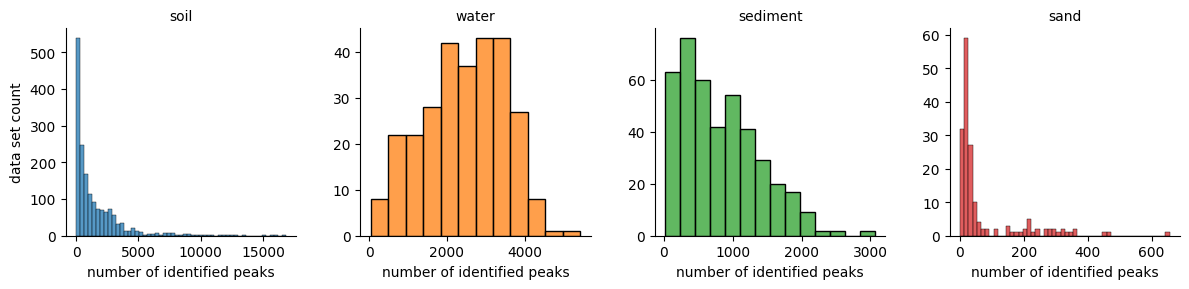

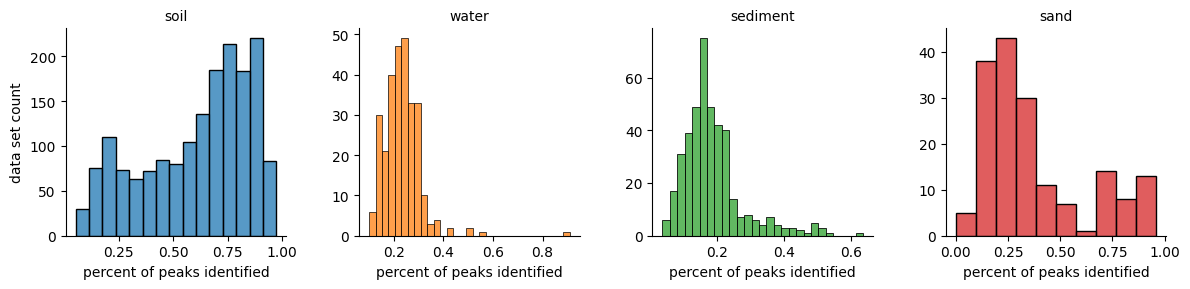

In [15]:
peak_count_plot=sns.FacetGrid(nom_summary_df,col="sample_type",hue="sample_type",sharex=False,sharey=False)
peak_count_plot.map(sns.histplot,'assigned_peak_count')
peak_count_plot.set_xlabels("number of identified peaks")
peak_count_plot.set_ylabels("data set count")
peak_count_plot.set_titles(col_template="{col_name}")

peak_perc_plot=sns.FacetGrid(nom_summary_df,col="sample_type",hue="sample_type",sharex=False,sharey=False)
peak_perc_plot.map(sns.histplot,'assigned_perc')
peak_perc_plot.set_xlabels("percent of peaks identified")
peak_perc_plot.set_ylabels("data set count")
peak_perc_plot.set_titles(col_template="{col_name}")

Apply filters to obtain high quality processed NOM data sets without removing all the files from any one sample type. Based on the figures above, requiring files to have at least 250 identified peaks that account for at least 30% of their total peak count will maintain a healthy number of data sets across sample types.

In [16]:
#filter data sets according to stats on peak assignment
nom_filt=nom_summary_df[nom_summary_df['assigned_peak_count']>=250]
nom_filt=nom_filt[nom_filt['assigned_perc']>=0.3]

#expand listed columns in molecular formula df
nom_filt_expanded=nom_filt.explode(['mol_form','H/C','O/C','Confidence Score'])

#resave expanded columns as numeric
nom_filt_expanded['O/C']=pd.to_numeric(nom_filt_expanded['O/C'])
nom_filt_expanded['H/C']=pd.to_numeric(nom_filt_expanded['H/C'])
nom_filt_expanded['Confidence Score']=pd.to_numeric(nom_filt_expanded['Confidence Score'])

#metadata group column
grouping_column='sample_type'

#count number of datasets in each type
count_type=nom_filt_expanded[['processed',grouping_column]].drop_duplicates().value_counts(grouping_column)

count_type

sample_type
soil        1089
sediment      41
water         31
sand          16
Name: count, dtype: int64

Randomly sample 15 data sets to visualize from each sample type

In [17]:
#determine sampling size based on counts above
n=15

#list the different types
list_type=count_type.index.tolist()

#for each type, randomly sample n data sets and save them into list
nom_sampled=[]
for type in list_type:
    #each processed ID and sample type
    nom_type=nom_filt_expanded[['processed',grouping_column]].drop_duplicates()
    #filter to current sample type
    nom_type=nom_type[nom_type[grouping_column]==type]
    #randomly sample n processed IDs in current sample type
    nom_type=nom_type.sample(n=n, random_state=2)
    #save
    nom_sampled.append(nom_type)

#resave list as dataframe
nom_sampled=pd.concat(nom_sampled)

#remerge rest of the data for the sampled data sets
nom_sampled=nom_sampled.merge(nom_filt_expanded,on=['processed',grouping_column],how="left")

nom_sampled

,processed,sample_type,assigned_peak_count,assigned_perc,mol_form,H/C,O/C,Confidence Score
0,nmdc:dobj-11-29erw821,soil,384,0.467153,C9 H10 O2,1.111111,0.222222,0.231132
1,nmdc:dobj-11-29erw821,soil,384,0.467153,C9 H18 O2,2.000000,0.222222,0.599805
2,nmdc:dobj-11-29erw821,soil,384,0.467153,C9 H18 O2,2.000000,0.222222,0.177271
3,nmdc:dobj-11-29erw821,soil,384,0.467153,C9 H16 O3,1.777778,0.333333,0.282521
4,nmdc:dobj-11-29erw821,soil,384,0.467153,C10 H20 O2,2.000000,0.200000,0.266828
...,...,...,...,...,...,...,...,...
107482,nmdc:dobj-13-6pfwjk47,sand,266,0.707447,C16 H30 O2,1.875000,0.125000,0.917770
107483,nmdc:dobj-13-6pfwjk47,sand,266,0.707447,C15 H30 O2 13C1,2.000000,0.133333,0.913212
107484,nmdc:dobj-13-6pfwjk47,sand,266,0.707447,C15 H30 O2,2.000000,0.133333,0.573382
107485,nmdc:dobj-13-6pfwjk47,sand,266,0.707447,C8 H16 O6 S1,2.000000,0.750000,0.086863


Filter to high confidence peaks (score greater than 0.3) and high frequency molecular formulas (present in more than 5 data sets). This will leave us with the most informative data.

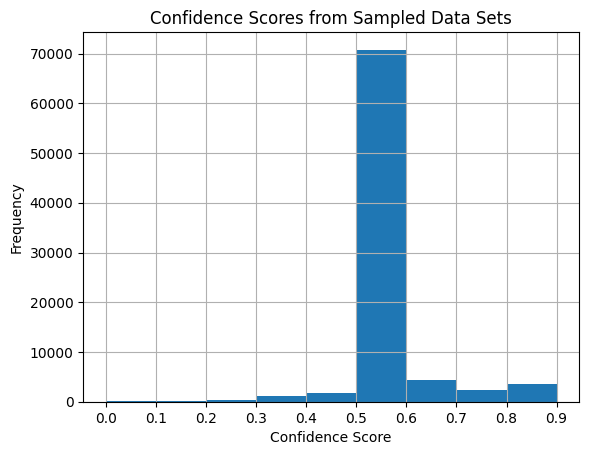

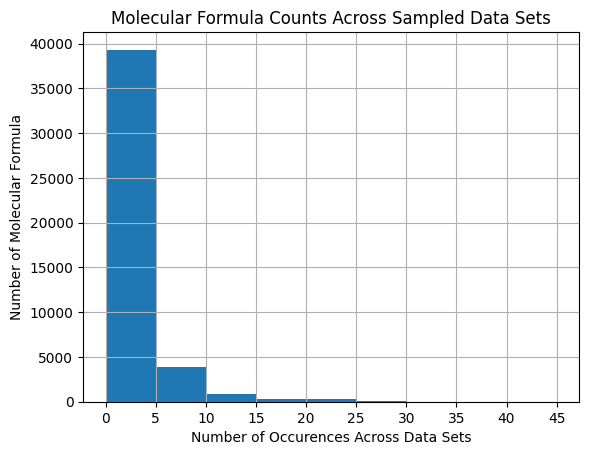

In [18]:
#histogram of confidence scores for randomly selected samples
nom_sampled.hist("Confidence Score",bins=np.arange(0,1,0.1))
plt.title('Confidence Scores from Sampled Data Sets')
plt.xlabel("Confidence Score")
plt.xticks(np.arange(0,1,0.1))
plt.ylabel("Frequency")
plt.show()

#peak filtering by confidence score
conf_filt=nom_sampled[nom_sampled['Confidence Score']>=0.3]

#count for each molecular formula
mol_counts=conf_filt.value_counts('mol_form').to_frame().reset_index()

#histogram of molecular formula counts
mol_counts.hist("count",bins=np.arange(0,50,5))
plt.locator_params(axis='x')
plt.title('Molecular Formula Counts Across Sampled Data Sets')
plt.xlabel("Number of Occurences Across Data Sets")
plt.xticks(np.arange(0,50,5))
plt.ylabel("Number of Molecular Formula")
plt.show()

#based on this histogram, filter to formulas in more than 5 data sets
mol_counts=mol_counts[mol_counts['count']>=5]
mol_filter=mol_counts.merge(conf_filt,on=['mol_form'],how="left")


### Assess patterns in the molecular formulas from different sample types

Create a clustermap of the processed NOM data sets (x axis), indicating the presence (black) or absence (white) of molecular formulas (y axis). The color bar will indicate sample type and help visualize the molecular similarity of data sets both within and between sample types.  

/home/bmeluch/NMDC/notebooks/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/bmeluch/NMDC/notebooks/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


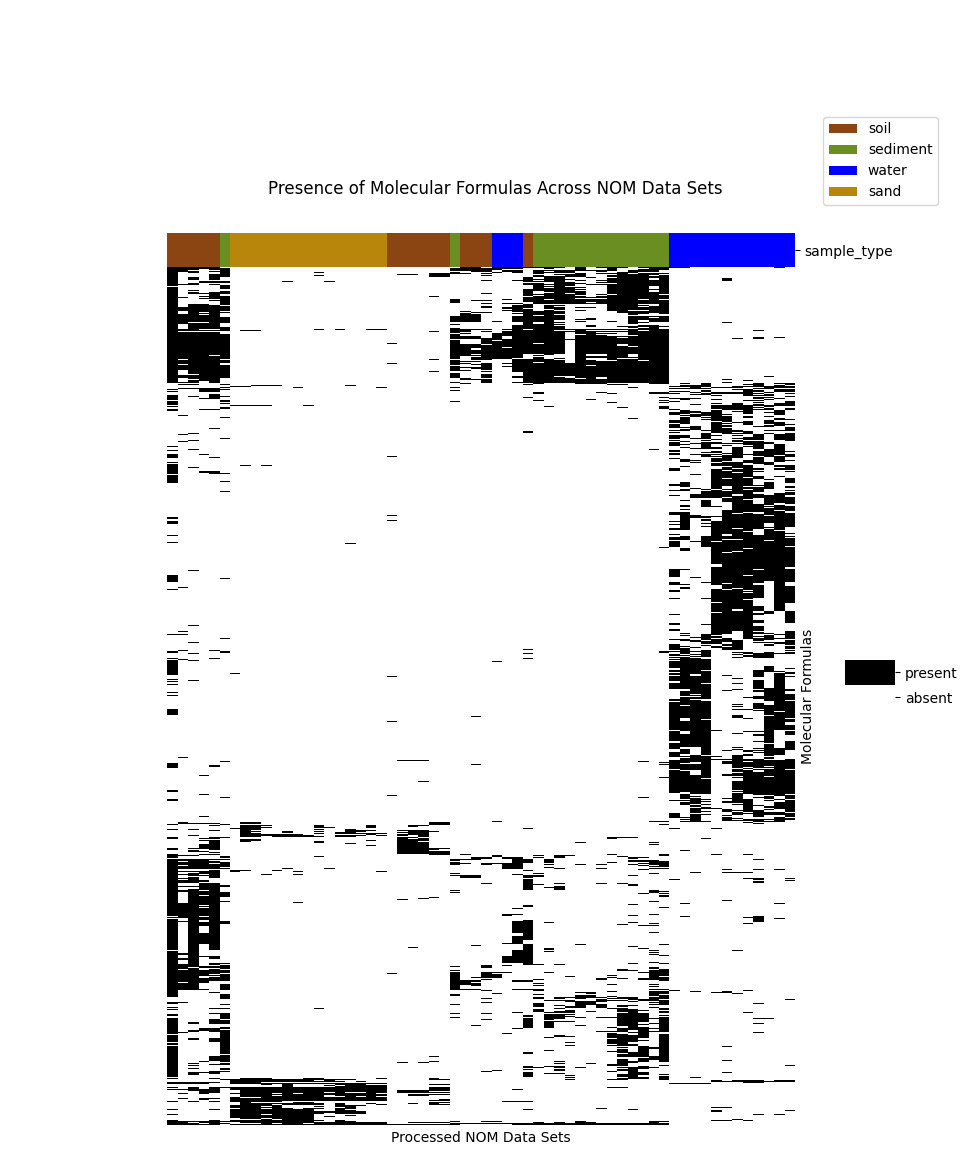

In [19]:

#sample type colors

#set colors for each sample type
type_col=pd.DataFrame({grouping_column:mol_filter[grouping_column].unique(),'color':['#8B4513','olivedrab','blue','#B8860B']})

#setup color legend for sample type
type_col_dict = dict(zip(type_col[grouping_column].unique(), ['#8B4513','olivedrab','blue','#B8860B']))
handles = [Patch(facecolor=type_col_dict[name]) for name in type_col_dict]

#map graph colors based on sample type to processed IDs
sample_type=mol_filter[[grouping_column,'processed']].drop_duplicates()
sample_type_col=sample_type.merge(type_col,how='left',on=grouping_column).set_index('processed').drop(grouping_column,axis=1).rename(columns={'color':grouping_column})

#presence/absence

#set colors for presence/absence as cmap
colors=['white','black']
custom_palette = sns.color_palette(colors)
custom_cmap = sns.color_palette(custom_palette, as_cmap=True)

#add column indicating presence in that processed nom id (1 is present)
mol_filter['presence']=1

#create presence/absence matrix. replace NA with 0 (0 is absent)
formula_matrix=mol_filter[['mol_form','processed','presence']].pivot_table('presence', index='mol_form', columns='processed').fillna(0).astype(int)

#heatmap (1 is present, zero is absent)
g=sns.clustermap(data=formula_matrix,col_colors=sample_type_col,tree_kws={"linewidths": 0.},xticklabels=False,yticklabels=False,cmap=custom_cmap)
g.figure.suptitle("Presence of Molecular Formulas Across NOM Data Sets")
g.ax_heatmap.set_xlabel("Processed NOM Data Sets")
g.ax_heatmap.set_ylabel("Molecular Formulas")

#adjust plot and legend locations
g.figure.subplots_adjust(top=1.15,right=0.8)
g.ax_cbar.set_position((0.85, 0.45, .05, .05)) #x axis,y axis, width, height

#adjust cbar legend to indicate presence/absence
g.ax_cbar.set_yticks([0.25,0.75])
g.ax_cbar.set_yticklabels(["absent","present"])

#add sample type legend
plt.legend(handles, type_col_dict, title=None,
           bbox_to_anchor=(0.95, 1.05), bbox_transform=plt.gcf().transFigure)

Create Van Krevelen diagrams to visually assess the atomic composition of each sample type. Van Krevelen diagrams plot the hydrogen to carbon ratio against the oxygen to carbon ratio, historically to assess petroleum samples.

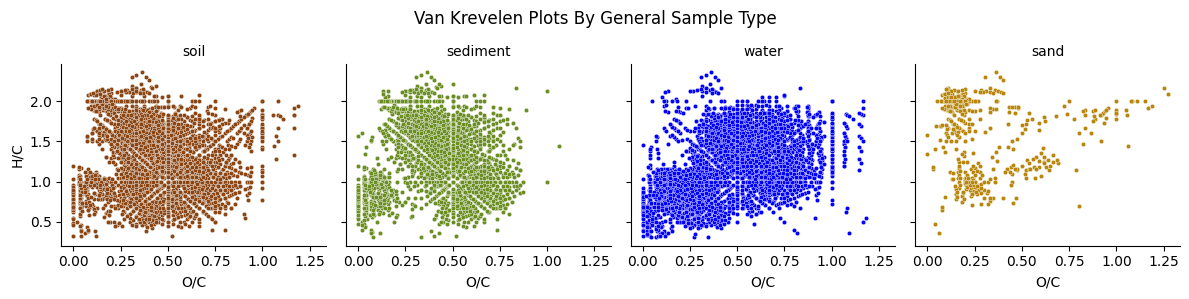

In [22]:
# the same molecular formula will have the same H/C and O/C value in every data set, so dots are only unique per sample type
vankrev_data=mol_filter[[grouping_column,'mol_form','H/C','O/C']].drop_duplicates()

#make van krevlen plot
g=sns.FacetGrid(vankrev_data,col=grouping_column,hue=grouping_column,palette=type_col_dict)
g.map(sns.scatterplot,'O/C','H/C',s=10)
g.set_titles(col_template="{col_name}")
g.figure.suptitle("Van Krevelen Plots By General Sample Type")
g.figure.subplots_adjust(top=0.8)

Create marginal density plot to assess how molecular formulas unique to each sample type compare to those shared by all four sample types.

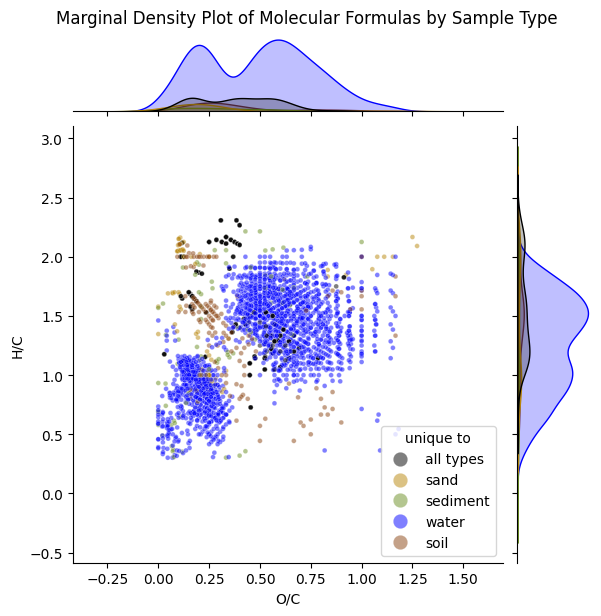

In [21]:
#count the number of sample types in which each molecular formula is found
density_counts=vankrev_data['mol_form'].value_counts()

#map counts back to H/C and O/C data
vankrev_data['common_to'] = vankrev_data['mol_form'].map(density_counts)

#filter molecular formual present in either all four sample types or in only one
vankrev_data=vankrev_data[vankrev_data['common_to'].isin([1,4])]

#reformat so sample type is 'all' when molecular formula was in all
vankrev_data.loc[vankrev_data['common_to']==4,'sample_type']='all types'

#add 'all' to sample type color dictionary
type_col_dict.update({'all types':'black'})

#make marginal density plot
sns.jointplot(data=vankrev_data, x="O/C", y="H/C", kind="scatter", hue=grouping_column,palette=type_col_dict,s=12,alpha=0.5)
plt.legend(markerscale=3,title="unique to")
plt.suptitle("Marginal Density Plot of Molecular Formulas by Sample Type",y=1.02)
plt.show()
